In [1]:
import os
base_path = '/kaggle/input/cleanedtabularcsv/cleaned_train.csv'

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the cleaned training data
train = pd.read_csv(base_path)
train.head(5)

,id,Basic_Demos-Age,Basic_Demos-Sex,age_group,CGAS_Score,Physical-BMI,BIA_Activity_Level,Fitness_Combined_Score,Physical_Composite_Index,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,5,0,Child,51.000000,16.877316,2.0,0.200000,0.184805,64.4,3.0,2.0
1,000fd460,9,0,Early Teen,65.156829,14.035590,2.0,0.400000,0.178587,64.0,0.0,0.0
2,00105258,10,1,Early Teen,65.156829,19.131648,3.0,0.583126,0.193319,54.0,2.0,0.0
3,00115b9f,9,0,Early Teen,71.000000,18.292347,3.0,0.400000,0.190185,45.0,0.0,1.0
4,001f3379,13,1,Teen,50.000000,22.279952,2.0,0.400000,0.217322,56.0,0.0,1.0


In [2]:
# Dropping a column by its name, since these columns were just used for EDA purpose and won't play any role in model training
train.drop(['age_group','id'], axis=1, inplace=True)

In [3]:
# checking the correlation of different features, to see if more features can be dropped
correlation_matrix = train.corr()
correlation_matrix

,Basic_Demos-Age,Basic_Demos-Sex,CGAS_Score,Physical-BMI,BIA_Activity_Level,Fitness_Combined_Score,Physical_Composite_Index,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
Basic_Demos-Age,1.000000,0.051229,-0.029053,0.474882,0.120009,-0.138492,0.308388,0.023892,0.437812,0.366290
Basic_Demos-Sex,0.051229,1.000000,0.092890,0.019980,-0.058695,0.057258,0.022087,-0.013311,-0.008187,-0.100743
CGAS_Score,-0.029053,0.092890,1.000000,-0.074201,0.043764,0.075232,-0.056137,-0.128933,-0.098636,-0.078660
Physical-BMI,0.474882,0.019980,-0.074201,1.000000,0.087225,-0.150247,0.490989,0.068604,0.296181,0.210449
BIA_Activity_Level,0.120009,-0.058695,0.043764,0.087225,1.000000,0.362169,-0.005036,-0.017993,0.012291,0.056299
Fitness_Combined_Score,-0.138492,0.057258,0.075232,-0.150247,0.362169,1.000000,-0.107525,-0.002418,-0.114181,-0.050159
Physical_Composite_Index,0.308388,0.022087,-0.056137,0.490989,-0.005036,-0.107525,1.000000,0.033919,0.163676,0.129886
SDS-SDS_Total_T,0.023892,-0.013311,-0.128933,0.068604,-0.017993,-0.002418,0.033919,1.000000,0.080753,0.240279
PreInt_EduHx-computerinternet_hoursday,0.437812,-0.008187,-0.098636,0.296181,0.012291,-0.114181,0.163676,0.080753,1.000000,0.338435
sii,0.366290,-0.100743,-0.078660,0.210449,0.056299,-0.050159,0.129886,0.240279,0.338435,1.000000


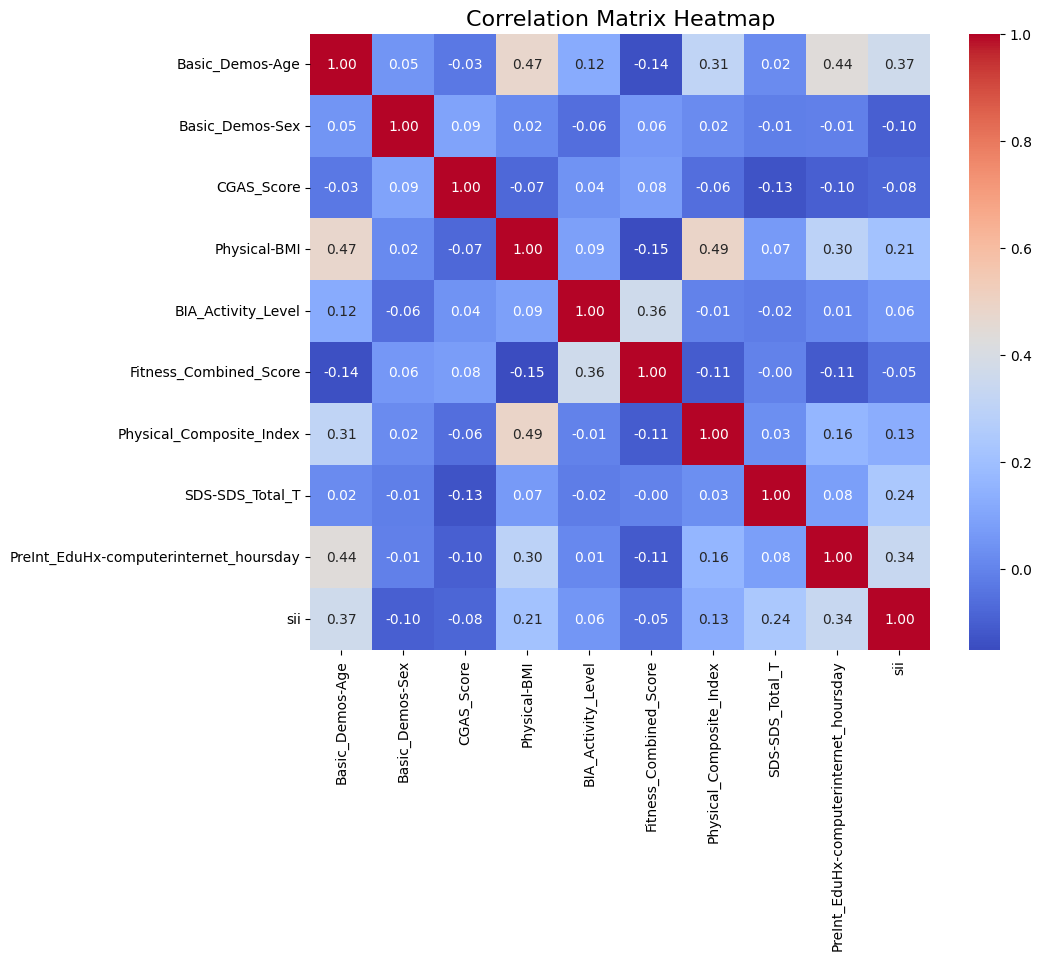

In [4]:
# Plot the correlation matrix as a heatmap to understand the correlation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.show()

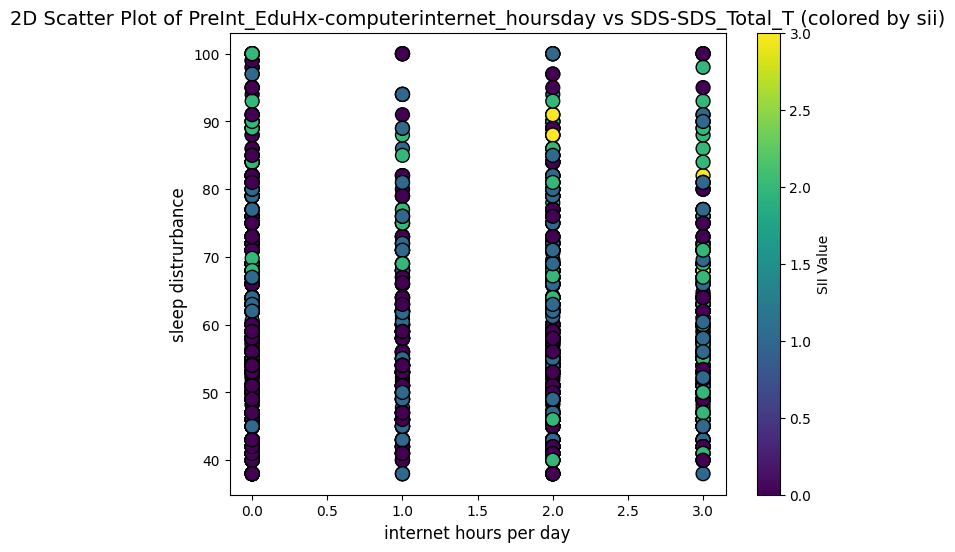

In [5]:
# Plotting the scatter plot between the most correlated features with the target variable to understand the distribution and behaviour of target variable with the feature variable
plt.figure(figsize=(8, 6))
scatter = plt.scatter(train['PreInt_EduHx-computerinternet_hoursday'], train['SDS-SDS_Total_T'], c=train['sii'], cmap="viridis", s=100, edgecolor="k")
plt.xlabel('internet hours per day', fontsize=12)
plt.ylabel('sleep distrurbance', fontsize=12)
plt.title(f"2D Scatter Plot of PreInt_EduHx-computerinternet_hoursday vs SDS-SDS_Total_T (colored by sii)", fontsize=14)
plt.colorbar(scatter, label=f"SII Value")
plt.show()

In [6]:
# checking only the most 3 top correlated features with the target variable to understand the relationship
x_feature = "PreInt_EduHx-computerinternet_hoursday"
y_feature = "SDS-SDS_Total_T"
z_feature = "Basic_Demos-Age"
target = "sii"

/tmp/ipykernel_17/86469814.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab10", num_colors)  # Use a discrete colormap


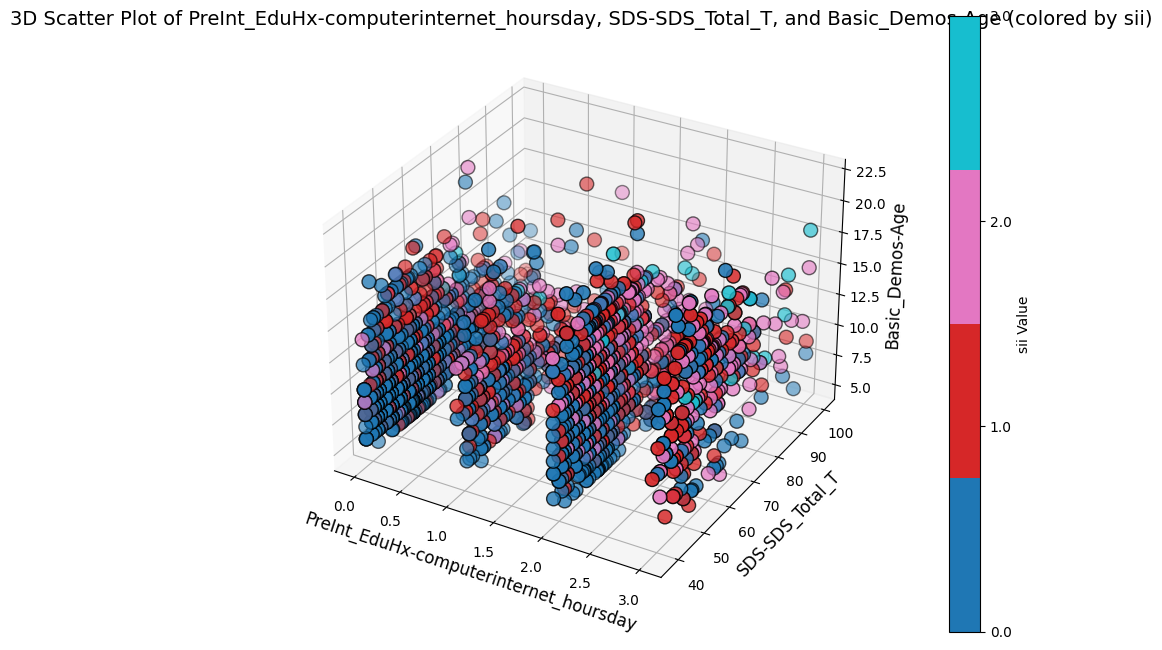

In [7]:
# plotting the scatter plots for them
from matplotlib import cm
#discrete colormap
unique_sii_values = sorted(train[target].unique())  # Unique sii values
num_colors = len(unique_sii_values)
cmap = cm.get_cmap("tab10", num_colors)  # Use a discrete colormap

# Mapping sii values to indices for coloring
color_indices = [unique_sii_values.index(value) for value in train[target]]

# a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    train[x_feature], 
    train[y_feature], 
    train[z_feature], 
    c=color_indices,  # Used mapped indices for colors
    cmap=cmap, 
    s=100, 
    edgecolor="k"
)

ax.set_xlabel(x_feature, fontsize=12)
ax.set_ylabel(y_feature, fontsize=12)
ax.set_zlabel(z_feature, fontsize=12)
ax.set_title(f"3D Scatter Plot of {x_feature}, {y_feature}, and {z_feature} (colored by {target})", fontsize=14)

cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_ticks(range(num_colors))
cbar.set_ticklabels(unique_sii_values)  # Map ticks to sii values
cbar.set_label(f"{target} Value")

plt.show()

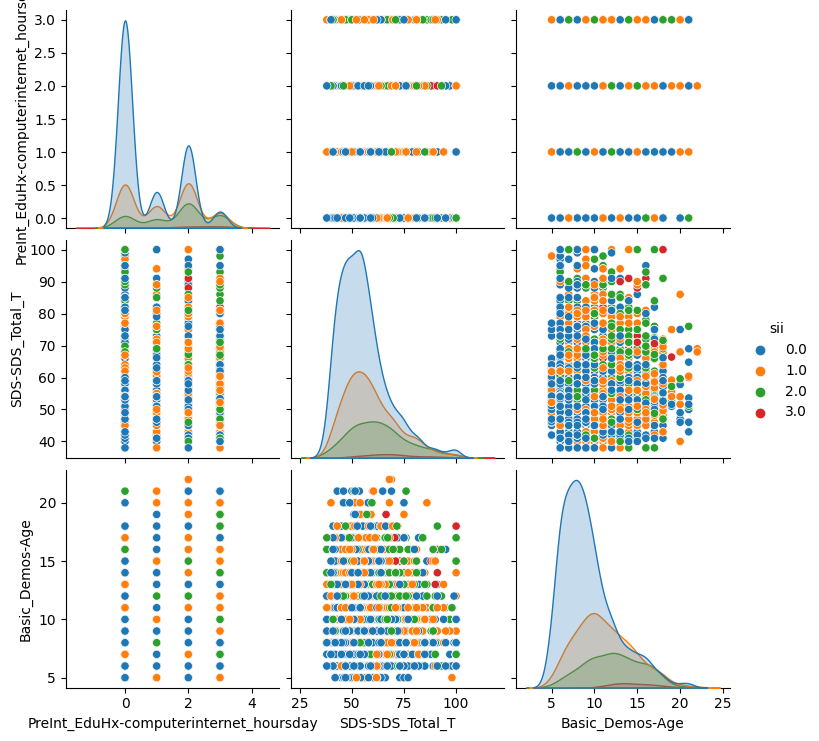

In [8]:
import seaborn as sns
import pandas as pd

# trying to work only with the most relevant columns
features = ["PreInt_EduHx-computerinternet_hoursday", "SDS-SDS_Total_T", "Basic_Demos-Age", "sii"]

# the pairplot with hue based on the 'sii' classes
sns.pairplot(train[features], hue="sii", palette="tab10")
plt.show()


A pairplot (scatterplot matrix) will help us in visualizing the pairwise relationships between all features. It can help identify which features have a better chance of separating the classes based on their pairwise relationships

sii
0.0    1589
1.0     730
2.0     377
3.0      34
Name: count, dtype: int64


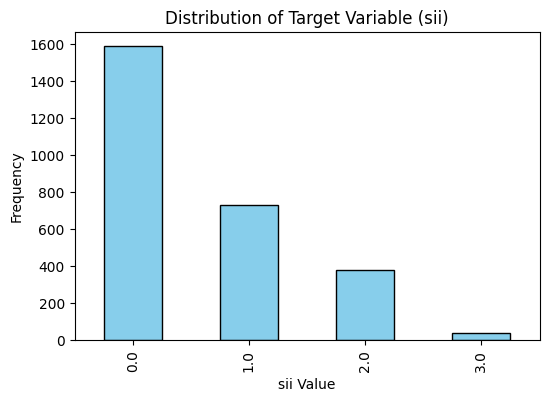

In [9]:
# Checking distribution of target variable 'sii'
class_counts = train["sii"].value_counts()
print(class_counts)
class_counts.plot(kind='bar', figsize=(6, 4), color='skyblue', edgecolor='black')
plt.title('Distribution of Target Variable (sii)')
plt.xlabel('sii Value')
plt.ylabel('Frequency')
plt.show()


Our dataset is very imbalanced and their is a impact of Imbalanced Data that is model bias. Our ML algo will be biased toward the majority class and will predict the majority class most of the time, leading to poor performance for the minority classes.
Since accuracy alone will not give a good indication of model performance when dealing with imbalanced datasets, we can use other metrics like Precision, Recall, and F1-Score
Confusion Matrix
ROC-AUC for multi-class classification

To handle imbalanced dataset, we can do resampling to make the dataset more balanced.
Since our data is already very limited, let's only try Oversampling (SMOTE)

In [10]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [11]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = train.drop(columns=["sii"])
y = train["sii"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {y_train.value_counts()}")
print(f"After SMOTE: {y_resampled.value_counts()}")


Before SMOTE: sii
0.0    1113
1.0     503
2.0     271
3.0      24
Name: count, dtype: int64
After SMOTE: sii
0.0    1113
1.0    1113
2.0    1113
3.0    1113
Name: count, dtype: int64


target variable (sii) after SMOTE to ensure that the classes are more balanced:

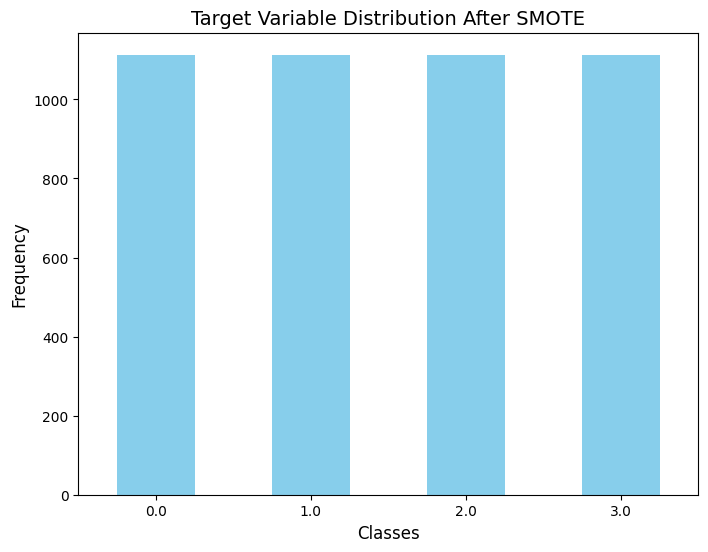

In [12]:
import matplotlib.pyplot as plt

# Checking the distribution of the target variable after SMOTE
plt.figure(figsize=(8, 6))
y_resampled.value_counts().plot(kind="bar", color="skyblue")
plt.title("Target Variable Distribution After SMOTE", fontsize=14)
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=0)
plt.show()


Visualizing the Decision Boundary

using techniques like PCA or t-SNE, we can try to find the hidden behaviour of features and understand how decision boundaries will look like in 2D

Dimensionality Reduction with PCA

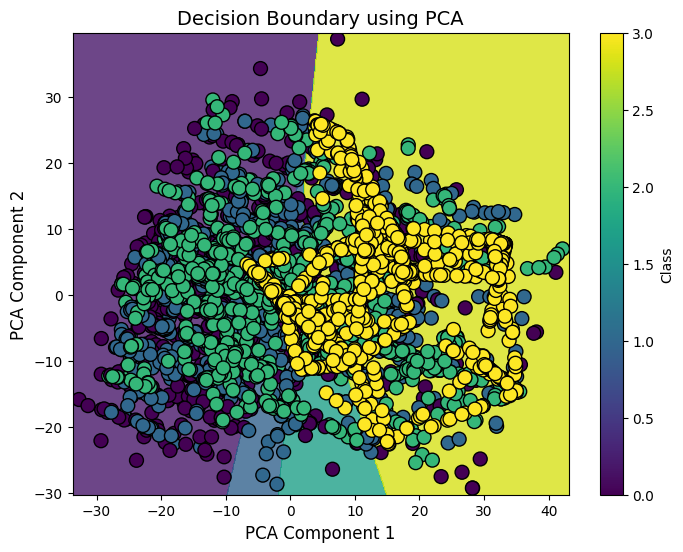

In [13]:
from sklearn.decomposition import PCA

# Apply PCA to reduce the feature space to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled)

# Plotting the decision boundary in the PCA space
from sklearn.svm import SVC
import numpy as np

# Training an SVM classifier
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_pca, y_resampled)

# Create a grid to plot decision boundaries
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Predict on each point of the grid
Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap="viridis")
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_resampled, edgecolor='k', cmap="viridis", s=100)
plt.title("Decision Boundary using PCA", fontsize=14)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.colorbar(label="Class")
plt.show()


Now trying with t-SNE

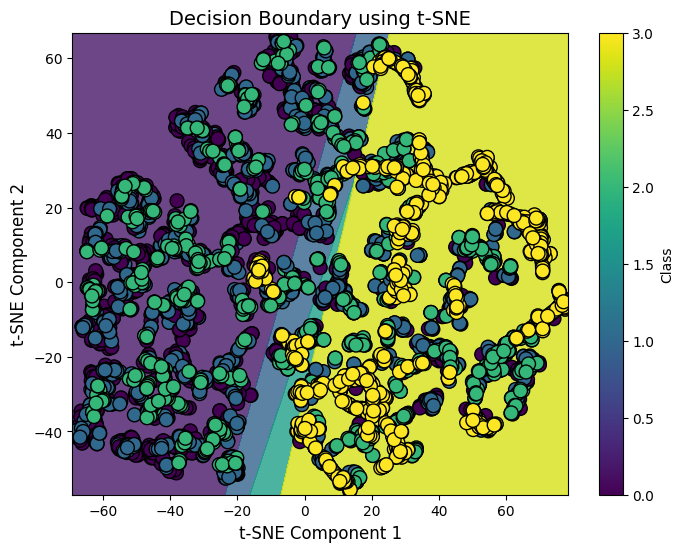

In [14]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce to 2D
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_resampled)

# Train an SVM classifier
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_tsne, y_resampled)

# Create a grid to plot decision boundaries
x_min, x_max = X_tsne[:, 0].min() - 1, X_tsne[:, 0].max() + 1
y_min, y_max = X_tsne[:, 1].min() - 1, X_tsne[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Predict on each point of the grid
Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap="viridis")
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_resampled, edgecolor='k', cmap="viridis", s=100)
plt.title("Decision Boundary using t-SNE", fontsize=14)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.colorbar(label="Class")
plt.show()


as we can see data is not linearly separable, we can try other types of kernels in the Support Vector Machine (SVM)

Radial Basis Function (RBF) Kernel (Gaussian Kernel) can be tried out as I suspect that the decision boundary is non-linear

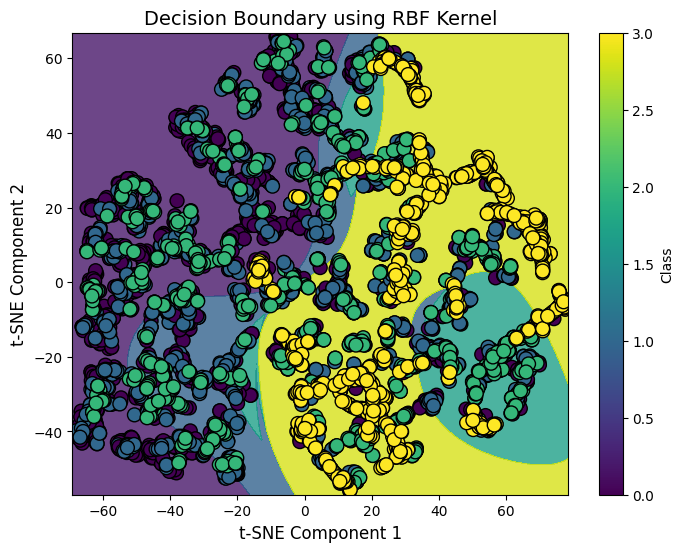

In [15]:
from sklearn.svm import SVC

# Train an SVM classifier with RBF kernel
svm_model_rbf = SVC(kernel='rbf', random_state=42)
svm_model_rbf.fit(X_tsne, y_resampled)

# Create a grid to plot decision boundaries
x_min, x_max = X_tsne[:, 0].min() - 1, X_tsne[:, 0].max() + 1
y_min, y_max = X_tsne[:, 1].min() - 1, X_tsne[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Predict on each point of the grid
Z = svm_model_rbf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap="viridis")
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_resampled, edgecolor='k', cmap="viridis", s=100)
plt.title("Decision Boundary using RBF Kernel", fontsize=14)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.colorbar(label="Class")
plt.show()


Trying polynomial Kernel

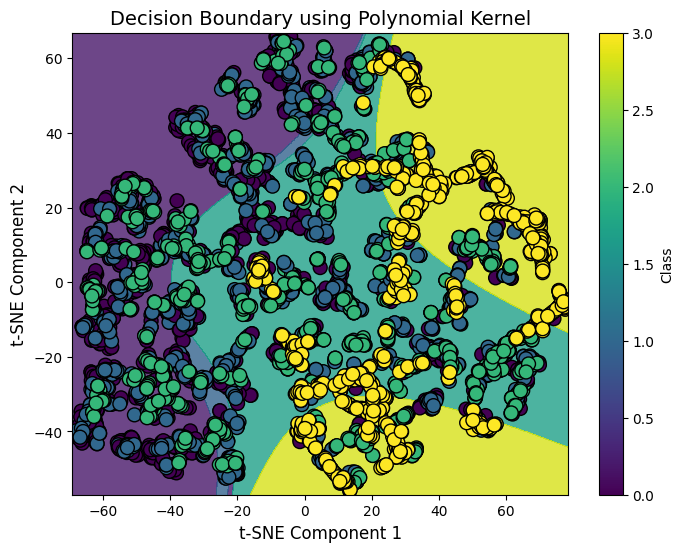

In [16]:
# Train an SVM classifier with Polynomial kernel
svm_model_poly = SVC(kernel='poly', degree=3, random_state=42)
svm_model_poly.fit(X_tsne, y_resampled)

# Predict on each point of the grid
Z = svm_model_poly.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap="viridis")
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_resampled, edgecolor='k', cmap="viridis", s=100)
plt.title("Decision Boundary using Polynomial Kernel", fontsize=14)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.colorbar(label="Class")
plt.show()


SVC uses“one-versus-one” approach for multi-class classification
In total, 4 * (4 - 1) / 2 = 6 classifiers are constructed and each one trains data from two classes.

LinearSVC implements “one-vs-the-rest” multi-class strategy, thus training n_classes models.

trying with Sigmoid

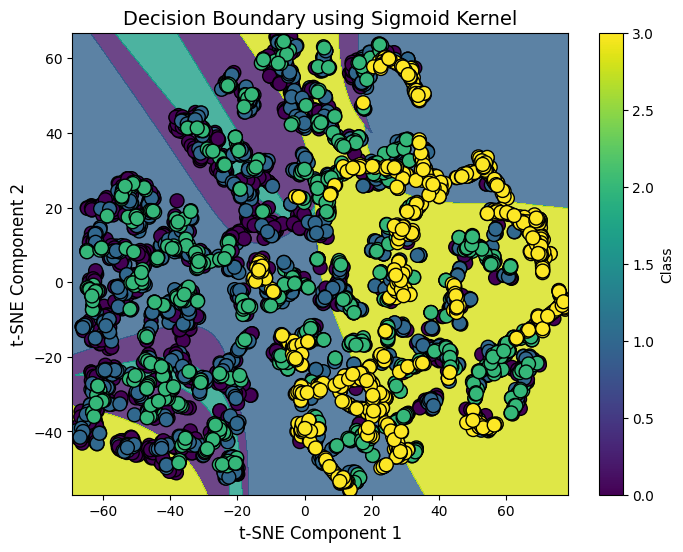

In [17]:
# Train an SVM classifier with Sigmoid kernel
svm_model_sigmoid = SVC(kernel='sigmoid', random_state=42)
svm_model_sigmoid.fit(X_tsne, y_resampled)

# Predict on each point of the grid
Z = svm_model_sigmoid.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap="viridis")
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_resampled, edgecolor='k', cmap="viridis", s=100)
plt.title("Decision Boundary using Sigmoid Kernel", fontsize=14)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.colorbar(label="Class")
plt.show()


Tuning the Hyperparameters

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best Score: 0.7949236298292902


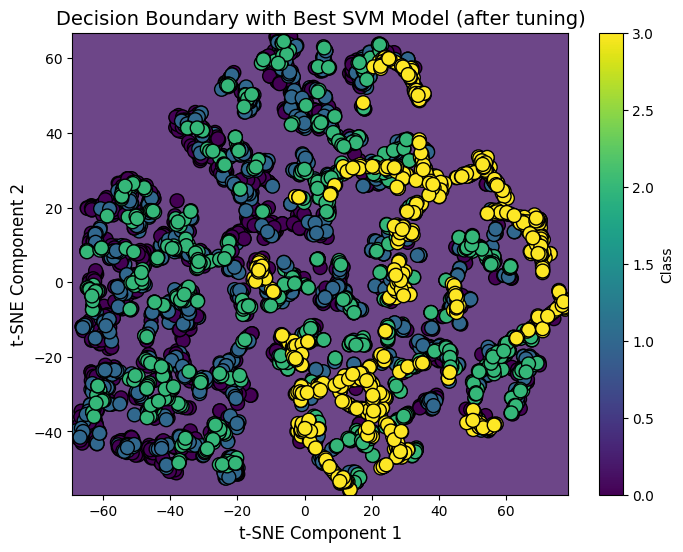

In [18]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for tuning
param_grid = {'C': [0.1, 1, 10],'gamma': ['scale', 'auto', 0.1, 1],'kernel':['rbf']}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(SVC(), param_grid, cv=3, verbose=1)
grid_search.fit(X_tsne, y_resampled)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Use the best model to predict and plot the decision boundary
best_model = grid_search.best_estimator_
Z = best_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap="viridis")
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_resampled, edgecolor='k', cmap="viridis", s=100)
plt.title("Decision Boundary with Best SVM Model (after tuning)", fontsize=14)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.colorbar(label="Class")
plt.show()


SMOTE vs. Class Weights
I though to check this, "If you're using class weights in SVM, you generally don't need SMOTE unless the performance is still not satisfactory and you want to further balance the dataset before training.
If the class imbalance is severe or class weights alone don't yield good performance, then SMOTE is a good alternative to improve the model."
so I tried to experiment with both methods and choose the one (or combination) that provides the best results for your specific case.

Class Weights in SVM (Without SMOTE)

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from collections import Counter

# Define X (features) and y (target)
X = train.drop('sii', axis=1)  # Exclude the target variable
y = train['sii']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Get the class distribution (to calculate class weights)
sii_dist = y_train.value_counts()

# Calculate class weights (inverse proportional to class frequency)
class_weights = {class_label: 1 / (count / len(y_train)) for class_label, count in sii_dist.items()}

# Train an SVM classifier with class weights
svm_model_weighted = SVC(kernel='rbf', class_weight=class_weights, random_state=42)

# Fit the model
svm_model_weighted.fit(X_train, y_train)

# Predict and evaluate the model
y_pred_weighted = svm_model_weighted.predict(X_test)
print("Classification Report for SVM with Class Weights:")
print(classification_report(y_test, y_pred_weighted))


Classification Report for SVM with Class Weights:
              precision    recall  f1-score   support

         0.0       0.74      0.67      0.70       312
         1.0       0.40      0.28      0.33       155
         2.0       0.18      0.26      0.21        72
         3.0       0.11      0.71      0.20         7

    accuracy                           0.51       546
   macro avg       0.36      0.48      0.36       546
weighted avg       0.56      0.51      0.53       546



Key Metrics:

Class 0.0: Precision = 0.74, Recall = 0.67, F1-score = 0.70
Class 1.0: Precision = 0.40, Recall = 0.28, F1-score = 0.33
Class 2.0: Precision = 0.18, Recall = 0.26, F1-score = 0.21
Class 3.0: Precision = 0.11, Recall = 0.71, F1-score = 0.20
Strengths:

Class 0.0: The precision and recall are decent, indicating that this class is relatively well-predicted.
Class 3.0: The high recall (0.71) suggests that it's being correctly identified, but precision is low, implying many false positives.
Weaknesses:

Classes 1.0 and 2.0: Both have low precision and recall, indicating that the model struggles to distinguish these classes well.
Macro avg: Precision = 0.36, Recall = 0.48, F1-score = 0.36 (indicating the model struggles with the minority classes overall).

SMOTE + SVM (With SMOTE)
use SMOTE to oversample the minority classes in the training set and then train the SVM on the balanced data.

In [20]:
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import classification_report


# Define X (features) and y (target)
X = train.drop('sii', axis=1)  # Exclude the target variable
y = train['sii']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to oversample the minority classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train an SVM classifier (without class weights) on the SMOTE balanced data
svm_model_smote = SVC(kernel='rbf', random_state=42)

# Fit the model
svm_model_smote.fit(X_train_smote, y_train_smote)

# Predict and evaluate the model
y_pred_smote = svm_model_smote.predict(X_test)
print("Classification Report for SVM with SMOTE:")
print(classification_report(y_test, y_pred_smote))


Classification Report for SVM with SMOTE:
              precision    recall  f1-score   support

         0.0       0.71      0.67      0.69       312
         1.0       0.39      0.20      0.26       155
         2.0       0.17      0.28      0.21        72
         3.0       0.11      0.86      0.19         7

    accuracy                           0.49       546
   macro avg       0.35      0.50      0.34       546
weighted avg       0.54      0.49      0.50       546



Key Metrics:

Class 0.0: Precision = 0.71, Recall = 0.67, F1-score = 0.69
Class 1.0: Precision = 0.39, Recall = 0.20, F1-score = 0.26
Class 2.0: Precision = 0.17, Recall = 0.28, F1-score = 0.21
Class 3.0: Precision = 0.11, Recall = 0.86, F1-score = 0.19
Strengths:

Class 3.0: SMOTE improves recall significantly for this class (0.86), but precision is still low (0.11).
Class 0.0: Precision is still relatively good, but recall has slightly decreased compared to the previous model.
Weaknesses:

Class 1.0: Recall drops to 0.20 (even worse than in the class weights case), which means the model is even worse at identifying this class.
Class 2.0: While recall has improved slightly, precision remains low (0.17).
Macro avg: Precision = 0.35, Recall = 0.50, F1-score = 0.34 (still showing issues with minority classes).

Combining Both: SMOTE + Class Weights in SVM
The combination of both methods, apply SMOTE first and then use class weights when training the SVM model.

In [21]:
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from collections import Counter

# Define X (features) and y (target)
X = train.drop('sii', axis=1)  # Exclude the target variable
y = train['sii']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to oversample the minority classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Get the class distribution after SMOTE (for calculating class weights)
sii_dist_smote = y_train_smote.value_counts()

# Calculate class weights (inverse proportional to class frequency)
class_weights_smote = {class_label: 1 / (count / len(y_train_smote)) for class_label, count in sii_dist_smote.items()}

# Train an SVM classifier with class weights on the SMOTE balanced data
svm_model_smote_weighted = SVC(kernel='rbf', class_weight=class_weights_smote, random_state=42)

# Fit the model
svm_model_smote_weighted.fit(X_train_smote, y_train_smote)

# Predict and evaluate the model
y_pred_smote_weighted = svm_model_smote_weighted.predict(X_test)
print("Classification Report for SVM with SMOTE and Class Weights:")
print(classification_report(y_test, y_pred_smote_weighted))


Classification Report for SVM with SMOTE and Class Weights:
              precision    recall  f1-score   support

         0.0       0.73      0.67      0.70       312
         1.0       0.41      0.26      0.32       155
         2.0       0.21      0.31      0.25        72
         3.0       0.11      0.86      0.19         7

    accuracy                           0.51       546
   macro avg       0.36      0.52      0.37       546
weighted avg       0.56      0.51      0.53       546



Key Metrics:

Class 0.0: Precision = 0.73, Recall = 0.67, F1-score = 0.70
Class 1.0: Precision = 0.41, Recall = 0.26, F1-score = 0.32
Class 2.0: Precision = 0.21, Recall = 0.31, F1-score = 0.25
Class 3.0: Precision = 0.11, Recall = 0.86, F1-score = 0.19
Strengths:

Class 0.0: Precision is still strong (0.73), and recall remains steady (0.67).
Class 3.0: Recall remains high (0.86), indicating that this class is still being identified correctly, though precision is low.
Class 1.0 and 2.0: There's a slight improvement in recall and precision compared to SMOTE-only, though not dramatic.
Weaknesses:

Class 3.0: The precision still remains low (0.11), which means a lot of false positives.
Class 1.0 and 2.0: These classes still face challenges with low precision and recall, though the combined approach seems to help slightly.
Macro avg: Precision = 0.36, Recall = 0.52, F1-score = 0.37 (overall, these results are still not stellar).

Class Weights: The class_weight parameter is set based on the distribution of the classes. SVM adjusts the decision boundary by assigning different penalties for misclassifying different classes.
SMOTE: SMOTE is used to oversample the minority classes in the training data, generating synthetic samples, and then the SVM model is trained on the balanced dataset.
SMOTE + Class Weights: First, SMOTE is applied to balance the dataset, and then class weights are used to fine-tune the SVM's decision boundary.

Comparative Summary:
SVM with Class Weights:

Best performance for Class 0.0, with reasonable recall and precision.
Struggles with Class 1.0 and Class 2.0 but performs decently on Class 3.0 due to the class weights.
Macro avg shows imbalanced performance with underperformance on the minority classes.
SVM with SMOTE:

Class 3.0 has significantly improved recall, but precision remains a concern.
Class 1.0 and Class 2.0 suffer with low recall (indicating the model is still having difficulty with these minority classes).
The results show a slight improvement over the class weights approach, but still not optimal.
SVM with SMOTE and Class Weights:

Class 0.0: Solid performance, with similar metrics as the class weights-only approach.
Class 1.0 and Class 2.0: There is some improvement in recall and precision, though it's still far from optimal.
Class 3.0: Recall is still high (0.86), but precision remains problematic.
Overall, this combination slightly improves the results over using SMOTE alone, but still, the class imbalance issue persists.

Combination of SMOTE and Class Weights seems to be the most effective approach, but it still struggles to achieve a well-balanced model across all classes, especially for Class 1.0 and Class 2.0.
If Class 3.0 is the most important (given its recall), this combination might work best.

In [22]:
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Prepare data (replace X and y with your actual features and target variables)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# SMOTE with more focus on Class 3.0
smote = SMOTE(sampling_strategy={3.0: 500}, random_state=42)  # Adjust Class 3.0 samples
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# SVM with RBF kernel and class weights (adjusted for Class 3.0)
class_weights = {0.0: 1.0, 1.0: 2.0, 2.0: 3.0, 3.0: 10.0}  # Focus on Class 3.0
svm_model = SVC(kernel='rbf', class_weight=class_weights, random_state=42)

# Train the SVM model
svm_model.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred = svm_model.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.72      0.70      0.71       476
         1.0       0.31      0.14      0.19       227
         2.0       0.11      0.02      0.03       106
         3.0       0.03      0.70      0.06        10

    accuracy                           0.46       819
   macro avg       0.29      0.39      0.25       819
weighted avg       0.52      0.46      0.47       819



updated results suggest that Class 3.0 is still being prioritized in terms of recall (0.70), but precision for Class 3.0 has dropped significantly to 0.03, indicating that most of the predictions for Class 3.0 are false positives. Additionally, the recall for Class 2.0 is quite low (0.02), and Class 1.0 has also seen a decrease in recall (0.14).

While increasing the weight for Class 3.0 helped its recall, it led to too many false positives, resulting in very low precision. we can try reducing the class weight for Class 3.0 slightly to balance recall and precision. It's also worth experimenting with increasing the weight for Class 2.0 and Class 1.0 to improve recall for these classes.

It looks like Class 1.0 and Class 2.0 still have low recall values. You could experiment with increasing the number of samples generated by SMOTE for these classes. By doing so, the model will see more samples for these classes and might learn better decision boundarie

In [23]:
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Prepare data (replace X and y with your actual features and target variables)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# SMOTE with more focus on Class 3.0
smote = SMOTE(sampling_strategy={1.0: 503, 2.0: 503, 3.0: 503}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# SVM with RBF kernel and class weights (adjusted for Class 3.0)
class_weights = {0.0: 1.0, 1.0: 2.0, 2.0: 3.0, 3.0: 5.0}  # Reduce weight for Class 3.0 slightly
svm_model = SVC(kernel='rbf', class_weight=class_weights, random_state=42)

# Train the SVM model
svm_model.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred = svm_model.predict(X_test)
# Print classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.74      0.64      0.69       476
         1.0       0.00      0.00      0.00       227
         2.0       0.14      0.36      0.21       106
         3.0       0.04      0.60      0.08        10

    accuracy                           0.43       819
   macro avg       0.23      0.40      0.24       819
weighted avg       0.45      0.43      0.43       819



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall this notebook, is just for understanding how to approach the model development, I will develop models in separate notebook